In [32]:
import pandas as pd
import numpy as np
import dask
from sklearn.pipeline import Pipeline


from dask.distributed import Client, LocalCluster
from dask_ml.model_selection import train_test_split


import joblib
from joblib import parallel_backend

import timeit

from dask_ml.model_selection import GridSearchCV
from dask_ml.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor


from dask_ml.wrappers import Incremental

from sklearn.metrics import mean_squared_error


from dask_ml.preprocessing import StandardScaler


from sklearn.pipeline import make_pipeline

from sklearn.linear_model import PassiveAggressiveRegressor

from sklearn.metrics import explained_variance_score

import dask.array as da

import matplotlib.pyplot as plt

In [2]:
cluster = LocalCluster(threads_per_worker = 1, n_workers = 2)

client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:49490 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.59 GB


In [97]:
df = pd.read_csv('large_cleaned_data.csv').drop('Unnamed: 0', 1)

In [ ]:
# graphing the dataframe

In [242]:
plot_df = df[['Date','Close']].copy()


In [252]:
plot_df['Date'] = plot_df['Date'].astype('datetime64')

In [ ]:
plot_df['Date'] = plot_df.Date.apply(lambda x: x.year)

In [255]:
plot_df = plot_df.groupby('Date').median()



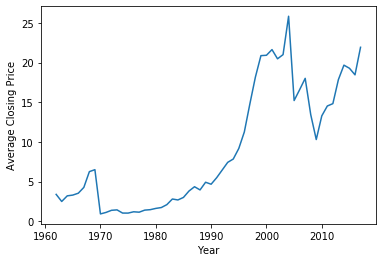

In [256]:
plt.plot(plot_df.index.values, plot_df.Close.values)
plt.ylabel('Average Closing Price')
plt.xlabel('Year')
plt.show()

In [ ]:
# next the dataframe is split 

In [5]:
X, y = df.drop(['Date', 'Close'], 1), df[['Close']]

In [6]:
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [8]:
X_train_da = da.from_array(X_train.values, chunks = (1000000, 4))
y_train_da = da.from_array(y_train.values, chunks = (1000000, 1))

X_test_da = da.from_array(X_test.values, chunks = (1000000, 4))
y_test_da = da.from_array(y_test.values, chunks = (1000000, 1))

In [9]:
X_train_da, y_train_da = dask.persist(X_train_da, y_train_da)
X_test_da, y_test_da = dask.persist(X_test_da, y_test_da)

In [10]:
# all features except volume correlate highly with each other

df.corr(method = 'kendall')

,Open,High,Low,Close,Volume
Open,1.000000,0.990558,0.990149,0.987289,0.100327
High,0.990558,1.000000,0.985858,0.990813,0.101652
Low,0.990149,0.985858,1.000000,0.990635,0.098998
Close,0.987289,0.990813,0.990635,1.000000,0.100360
Volume,0.100327,0.101652,0.098998,0.100360,1.000000


In [11]:
# this correlation appears to be linear, so regression will model the relationships nicely

df.corr(method = 'pearson')

,Open,High,Low,Close,Volume
Open,1.000000,0.999713,0.999374,0.998930,-0.001500
High,0.999713,1.000000,0.999448,0.999476,-0.001498
Low,0.999374,0.999448,1.000000,0.999651,-0.001506
Close,0.998930,0.999476,0.999651,1.000000,-0.001501
Volume,-0.001500,-0.001498,-0.001506,-0.001501,1.000000


In [12]:
est = PassiveAggressiveRegressor()
parameters = {'C': [.5,1,2]}

In [13]:
start = timeit.default_timer()
search = GridSearchCV(est, parameters, cv = 3).fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

101.07403971400001


In [14]:
inc = Incremental(PassiveAggressiveRegressor(C=search.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc.fit(X_train_da, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

2.1451425490000133


In [15]:
# r2 score

inc.score(X_test_da, y_test_da)

0.9994096590670168

In [16]:
# explained variance score

explained_variance_score(y_test, inc.predict(X_test))

0.9994097411081627

In [17]:
# mean-squared error

mean_squared_error(y_test, inc.predict(X_test))

0.0005555187512746314

In [18]:
#####################################################
# let's try one variable since the scores are so high
#####################################################

In [19]:
X_train_da2 = da.from_array(X_train.Open.values.reshape(-1,1), chunks = (1000000, 1))

X_test_da2 = da.from_array(X_test.Open.values.reshape(-1,1), chunks = (1000000, 1))

In [20]:
X_train_da2, X_test_da2 = dask.persist(X_train_da2, X_test_da2)

In [21]:
start = timeit.default_timer()
search2 = GridSearchCV(est, parameters, cv = 3).fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

70.86607497000003


In [22]:
inc2 = Incremental(PassiveAggressiveRegressor(C=search2.best_estimator_.get_params()['C']))

start = timeit.default_timer()
inc2.fit(X_train_da2, y_train_da.ravel())
end = timeit.default_timer()

print(end - start)

1.7476070349999873


In [23]:
# r2 score

inc2.score(X_test_da2, y_test_da)

0.9932683380144124

In [24]:
# explained variance score

explained_variance_score(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.99691613084817

In [25]:
# mean-squared error

mean_squared_error(y_test, inc2.predict(X_test.Open.values.reshape(-1,1)))

0.006334584392343516

In [26]:
# one variable seems to suffice
# let's check the results on a different data set

In [27]:
df2 = pd.read_csv('cleaned_data.csv').rename(columns = {'Unnamed: 0':'date'})

In [28]:
import re
matches = {i:re.search('2018.*', df2.date[i]) for i in range(len(df2.date)) 
           if re.search('2018.*', df2.date[i]) is not None}


In [29]:
# df2_scaled = StandardScaler()\
#     .fit_transform(df2[list(matches.keys())[0]:list(matches.keys())[-1]+1].open.values.reshape(-1,1))

In [30]:

# inc2.score(df2[list(matches.keys())[0]:list(matches.keys())[-1]+1]
#                                       .open.values.reshape(-1,1), 
#            df2.close.values[list(matches.keys())[0]:list(matches.keys())[-1]+1].reshape(-1,1))

In [31]:
# explained variance score

explained_variance_score(df2.close.values[list(matches.keys())[0]:list(matches.keys())[-1]+1], 
                         inc2.predict(df2[list(matches.keys())[0]:list(matches.keys())[-1]+1]
                                      .open.values.reshape(-1,1)))

0.9146352061649307